In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
from mpl_toolkits.axes_grid1 import ImageGrid

from src.loaders import FrameLoader, LabelsLoader

In [2]:
frame_loader = FrameLoader('data/a9_r0_dataset_undistorted/images')
labels_loader = LabelsLoader('data/a9_r0_dataset_undistorted/labels')

In [3]:
# Create dataframe for labels.

data = {
    'frame': [],
    'camera': [],
    'category': [],
    'length': [],
    'width': [],
    'height': [],
}
for i, (labels, labels_data) in enumerate(labels_loader.load_items()):
    for label in labels:
        data['frame'].append(i)
        data['camera'].append(labels_data['image_file_name'][21:49])

        data['category'].append(label.category)

        length, width, height = label.dimensions
        data['length'].append(length)
        data['width'].append(width)
        data['height'].append(height)

labels_df = pd.DataFrame(data)

In [4]:
# Number of labeled vehicles per frame.

frames_df = pd.DataFrame(
    {
        'labels': labels_df.frame.value_counts().sort_index(),
        'camera': labels_df.camera.groupby(labels_df.frame).first(),
    }
)

px.bar(
    frames_df,
    y='labels',
    color='camera',
    hover_data=['camera'],
    labels={'index': 'frame index', 'labels': '# labels'},
)

In [5]:
# Number of labels and dimension statistics per category.

columns = ['length', 'width', 'height']
category_group = labels_df[columns].groupby(labels_df.category)
quantiles = category_group.quantile([0.02, 0.98])
means = category_group.mean()
counts = labels_df.category.value_counts()

for category in labels_df.category.unique():
    lower = quantiles.loc[category].iloc[0].values
    higher = quantiles.loc[category].iloc[1].values
    mean = means.loc[category].values

    print(f'{category} ({counts[category]})')
    for dim, (l, h, m) in zip(columns, list(zip(lower, higher, mean))):
        print(f'    {dim} Ø {m:05.2f} ({l:05.2f} -> {h:05.02f})', end='')
    print('')

CAR (8158)
    length Ø 04.60 (03.24 -> 04.89)    width Ø 01.94 (01.58 -> 02.12)    height Ø 01.46 (01.23 -> 01.77)
VAN (1174)
    length Ø 05.74 (04.10 -> 07.83)    width Ø 02.06 (01.64 -> 02.59)    height Ø 02.17 (01.62 -> 02.91)
TRAILER (1048)
    length Ø 11.81 (03.62 -> 18.04)    width Ø 02.52 (01.93 -> 02.90)    height Ø 03.59 (01.42 -> 04.28)
TRUCK (853)
    length Ø 05.81 (02.18 -> 15.00)    width Ø 02.51 (02.01 -> 02.75)    height Ø 03.56 (02.13 -> 04.01)
SPECIAL_VEHICLE (9)
    length Ø 07.28 (03.57 -> 10.27)    width Ø 02.36 (02.00 -> 02.73)    height Ø 02.87 (01.58 -> 03.62)
BUS (59)
    length Ø 13.58 (09.57 -> 18.77)    width Ø 02.61 (02.44 -> 02.92)    height Ø 03.35 (02.98 -> 03.96)
BICYCLE (1)
    length Ø 01.42 (01.42 -> 01.42)    width Ø 00.48 (00.48 -> 00.48)    height Ø 01.24 (01.24 -> 01.24)
MOTORCYCLE (33)
    length Ø 02.32 (01.67 -> 04.75)    width Ø 00.75 (00.50 -> 01.46)    height Ø 01.64 (01.50 -> 01.90)
PEDESTRIAN (20)
    length Ø 00.56 (00.49 -> 01.28)   

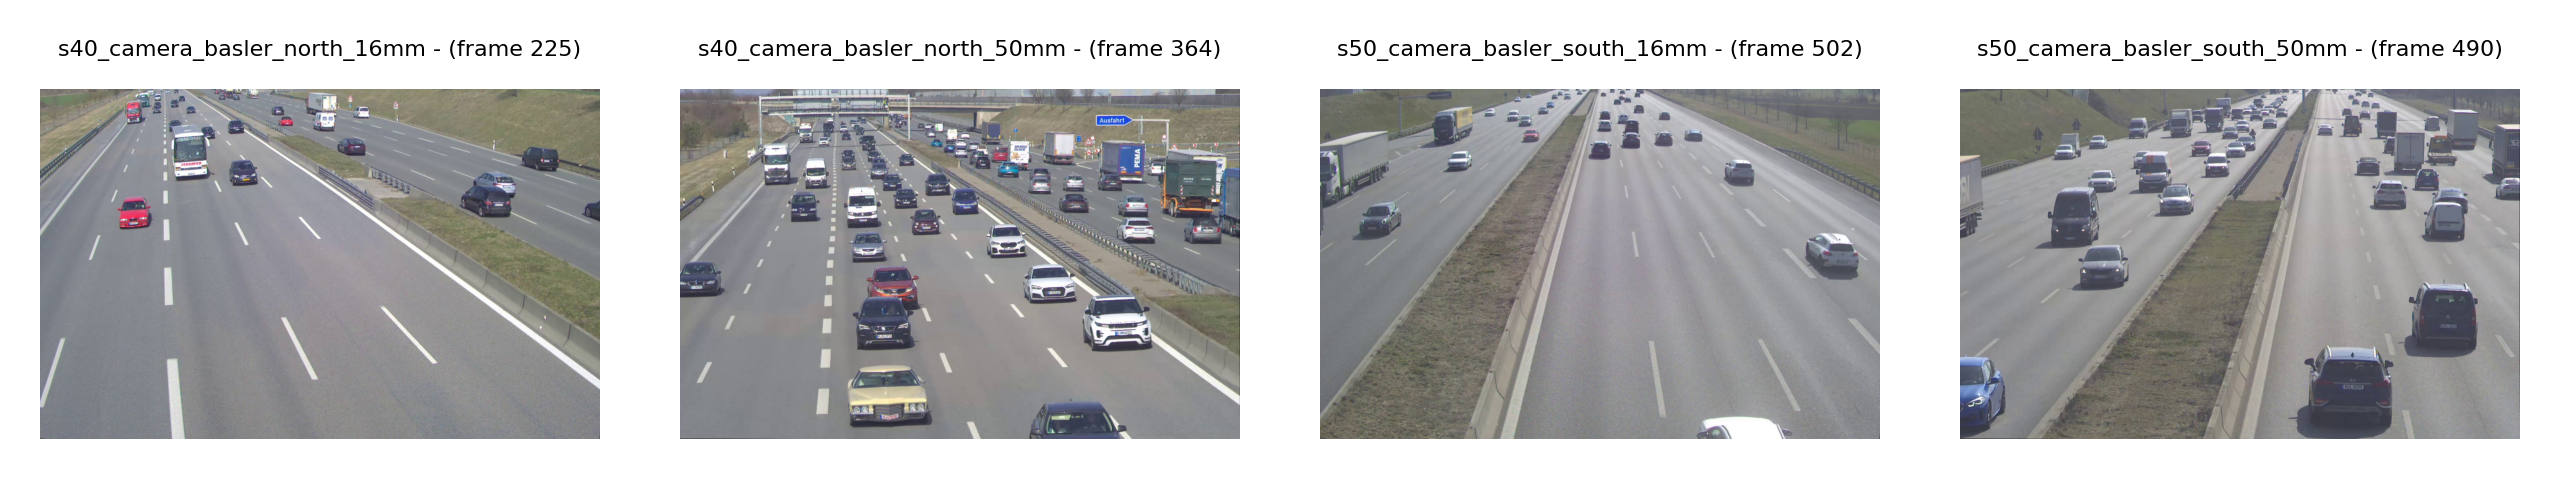

In [6]:
# Show frames with most labels per camera.

frame_ids = frames_df.groupby('camera').idxmax().labels

fig = plt.figure(figsize=(8, 2), dpi=400)
grid = ImageGrid(fig, 111, nrows_ncols=(1, 4), axes_pad=0.2)
for ax, (camera, frame_id) in zip(grid, frame_ids.items()):
    frame = frame_loader.load_item(frame_id)
    ax.imshow(frame)
    ax.axis('off')
    ax.set_title(f'{camera} - (frame {frame_id})', {'fontsize': 4})
plt.show()